# Formulate Full-Space and Reduced-Space Neural Networks in OMLT

### In this example we show how different neural networks can be formulated using Pyomo and OMLT.

In [1]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

import pyomo.environ as pyo
#from tensorflow.keras.models import load_model

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import pandas as pd
import numpy as np
import json

tf.keras.backend.set_floatx('float64')

In [20]:
from omlt import OmltBlock
from omlt.neuralnet import NetworkDefinition, NeuralNetworkFormulation,ComplementarityReLUActivation
from omlt.io import keras_reader
import omlt

## Import the Data

For demonstration purposes, we trained a neural network that learned a simple sin wave function given by:
$y=sin(\omega x) + x^2$ on the interval $x \in [-2,2]$

In [4]:
#load the original training data
df = pd.read_csv("keras_model_sin_wave/sinwave_dataset.csv")
df

,Unnamed: 0,x,y,x_scaled,y_scaled
0,0,-2.0000,4.544021,-1.731791,2.328999
1,1,-1.9996,4.540742,-1.731445,2.326620
2,2,-1.9992,4.537460,-1.731098,2.324239
3,3,-1.9988,4.534177,-1.730752,2.321858
4,4,-1.9984,4.530892,-1.730405,2.319475
...,...,...,...,...,...
9995,9995,1.9984,3.456311,1.730405,1.539920
9996,9996,1.9988,3.456225,1.730752,1.539857
9997,9997,1.9992,3.456140,1.731098,1.539796
9998,9998,1.9996,3.456058,1.731445,1.539737


The training data captures the function of interest and is plotted below

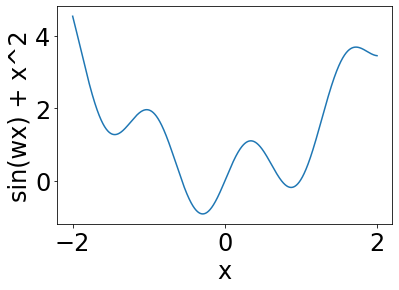

In [5]:
x = df["x"]
y = df["y"]
plt.plot(x,y)
plt.xlabel("x")
plt.ylabel("sin(wx) + x^2");

## Train the Neural Network

In [6]:
model1 = Sequential(name='sin_wave')

model1.add(Input(1))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(1))
model1.compile(optimizer=Adam(), loss='mse')

In [7]:
history = model1.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=10)

Epoch 1/10
313/313 [==============================] - 1s 3ms/step - loss: 0.2387
Epoch 2/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0747
Epoch 3/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0594
Epoch 4/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0384
Epoch 5/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0108
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0014
Epoch 7/10
313/313 [==============================] - 2s 7ms/step - loss: 6.0876e-04
Epoch 8/10
313/313 [==============================] - 2s 6ms/step - loss: 6.7785e-04
Epoch 9/10
313/313 [==============================] - 2s 6ms/step - loss: 7.1165e-04
Epoch 10/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0011


### Importantly, we use scaling information and training to formulate neural networks in OMLT

In [8]:
#load scaling and bounds
with open("keras_model_sin_wave/scale.json", 'r') as f:
    scales = json.load(f)
    f.close()

with open("keras_model_sin_wave/bounds.json", 'r') as f:
    bounds = json.load(f)
    f.close()
print("scaling data: ",scales)
print("training bounds: ",bounds)

scaling data:  {'mean': {'x': -5.10702591327572e-18, 'y': 1.3336000266693333}, 'std': {'x': 1.1548737593388, 'y': 1.3784554666712947}}
training bounds:  {'min': {'x': -2.0, 'y': -0.9086219566495785}, 'max': {'x': 2.0, 'y': 4.5440211108893696}}


## Check the predictions

In [9]:
y_predict_scaled = model1.predict(x=df['x_scaled'])
y_predict = y_predict_scaled*(scales['std']["y"]) + scales['mean']["y"]

### We load the neural network from Keras and show a decent fit to our simple sin curve

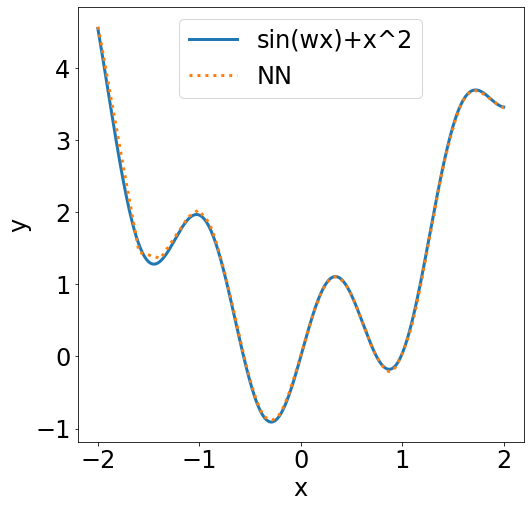

In [10]:
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "sin(wx)+x^2")
ax.plot(x,y_predict,linewidth = 3.0,linestyle="dotted",label = "NN")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

## Formulating the OMLT Model

In [11]:
model = pyo.ConcreteModel()
model.nn = OmltBlock()

#the neural net contains one input and one output
model.input = pyo.Var()
model.output = pyo.Var()

In [12]:
scale_x = [scales['mean']['x'],scales['std']['x']]
scale_y = [scales['mean']['y'],scales['std']['y']]
scaler = omlt.scaling.OffsetScaling(offset_inputs=[scale_x[0]],
                    factor_inputs=[scale_x[1]],
                    offset_outputs=[scale_y[0]],
                    factor_outputs=[scale_y[1]])
input_bounds=[(bounds['min']['x']),bounds['max']['x']]

print(scaler)
print(input_bounds)

[-2.0, 2.0]


In [24]:
net = omlt.io.load_keras_sequential(model1,scaler,input_bounds)
print(net)

NetworkDefinition(num_layers=5)


In [17]:
net.scaling_object = scaler

In [18]:
net.input_bounds

[-2.0, 2.0]

In [31]:
list(net.layers)

[<InputLayer(input_size=[1], output_size=[1]) at 0x7fa158413910>,
 <DenseLayer(input_size=[1], output_size=[100]) at 0x7fa158413cd0>,
 <DenseLayer(input_size=[100], output_size=[100]) at 0x7fa158413e90>,
 <DenseLayer(input_size=[100], output_size=[100]) at 0x7fa158413d90>,
 <DenseLayer(input_size=[100], output_size=[1]) at 0x7fa158413bd0>]

[<DenseLayer(input_size=[100], output_size=[1]) at 0x7fa158413bd0>,
 <DenseLayer(input_size=[100], output_size=[100]) at 0x7fa158413d90>,
 <DenseLayer(input_size=[100], output_size=[100]) at 0x7fa158413e90>,
 <DenseLayer(input_size=[1], output_size=[100]) at 0x7fa158413cd0>,
 <InputLayer(input_size=[1], output_size=[1]) at 0x7fa158413910>]

## Multiple neural network formulations are possible. These include: 
FullSpaceContinuousFormulation, ReducedSpaceContinuousFormulation, ReLUBigMFormulation, ReLUComplementarityFormulation

## FullSpaceContinuousFormulation 
### TODO: write out what this formulation is

In [25]:
#hides the intermediate variables from the optimizer
formulation = NeuralNetworkFormulation(net,activation_constraints={
            "relu": ComplementarityReLUActivation()})

#formulation = ReducedSpaceContinuousFormulation(net)

#build the formulation on the OMLT block

model.nn.build_formulation(formulation)

#query inputs and outputs, as well as scaled inputs and outputs
#model.nn.inputs_list
#model.nn.outputs_list
#model.nn.scaled_inputs_list
#model.nn.scaled_outputs_list

    'pyomo.core.base.set.OrderedScalarSet'>) on block nn with a new Component
    (type=<class 'pyomo.core.base.set.AbstractOrderedScalarSet'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block nn with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.set.OrderedScalarSet'>) on block nn with a new Component
    (type=<class 'pyomo.core.base.set.AbstractOrderedScalarSet'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block nn with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid

TypeError: 'float' object is not subscriptable

### Solving the Pyomo Model
Now we solve an inverse problem over the neural network to find an input that produces the desired output <br>
$\min (\hat{y} - p)^2$ <br>
$s.t. \hat{y} = N(x)$

In [ ]:
model.obj = pyo.Objective(expr=(model.output - 0.5)**2)
status = pyo.SolverFactory('ipopt').solve(model, tee=False)
print(pyo.value(model.input))
print(pyo.value(model.output))

In [ ]:
formulation = FullSpaceContinuousFormulation(net)

In [ ]:
formulation = ReLUBigMFormulation(net)

In [65]:
formulation = ReLUComplementarityFormulation(net)

NameError: name 'ReLUComplementarityFormulation' is not defined

## FullSpaceContinuousFormulation 
### TODO: write out what this formulation is

